## Table of Contents
1.  [Problem statement](#1.-Problem_Statement)

    1.1  [Data](#1.1-Dataset_Description:)   
    1.2  [Error-Metric](#1.2-Error_Metric)     
    1.3  [Libraries](#1.3-Libraries)   
    1.4  [Data Reading](#1.4-Reading_Data)

2.  [Exploratory Data Analysis](#2.-Exploratory_Data_Analysis)
3.  [Observations](#3.-Observations)     
4.  [Model buillding](#4.-Model_Building)
5.  [Overall_Insights](#5.-Overall_Insights)

### 1. Problem_Statement
#### Sales forecasting of a pharmaceutical retail chain

    KioMed, a huge pharmaceutical retailer, operates in in 10+ cities across India. The 
    company has one distribution warehouse in each of the cities it operates in. 
    Unfortunately, the warehouses are not able to consistently meet the demand of the 
    stores in their respective cities. Kio, the parent company, being a data driven 
    corporation wants to solve the stocking / inventory management problem using their 
    in-house data science team. 
    
    The retailer has provided you with historical sales data and is looking to forecast the 
    sales for the period of one month after the end of the data. These forecasts will be 
    used to ensure that the company is able to stock its supplies of medicines in a 
    warehouse accordingly in each city for a period of one month. 
    
    The company will also provide you with the footfall data for all the stores across each 
    of its cities. You can use this data, but as in the case of the real world, the footfall data 
    is only available at train time and not at test time 

### 1.1 Dataset_Description:
The following datasets are given: 
    
    ● train_data.csv: year, month, day, city, medicine, sales
    ● test_data.csv: id, year, month, day, city, medicine
    ● foot_fall.csv: footfall at all the stores in each city on a given day
    ● city_dict.json: a dictionary mapping the integer value present in the train and 
    test datasets to the actual city
    ● discount_features.csv : discounts on medicines
    ● sample_submission.csv: id, sales

### 1.2 Error_Metric : RMSE(Root Mean Square Error)

### 1.3 Libraries

In [134]:
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from scipy.stats import uniform, truncnorm, randint
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import StratifiedShuffleSplit

from xgboost import XGBClassifier
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### 1.4 Reading_Data

In [2]:
#Reading the data normally
dataSource = 'train_data-1638436039700.csv'
data=pd.read_csv(dataSource, na_values=['unknown', '#', '$'])

In [3]:
#Reading the data as time series
df = pd.read_csv(dataSource,
                 parse_dates= {"date" : ["year","month","day"]}, index_col="date", na_values=['unknown', '#', '$'])

In [4]:
#Reading the foot fall data
foot_fall = pd.read_csv("foot_fall-1638434879770.csv")

In [5]:
#Reading discount data
disc_df = pd.read_csv("discount_features-1638436205304.csv")

In [6]:
#Reading the json file
import json
 
# Opening JSON file
f = open('city_dict.json')
 
# returns JSON object as
# a dictionary
data_city = json.load(f)
 
print(data_city)
 

f.close()

{'4': 'Mumbai', '5': 'Delhi', '7': 'Bangalore', '1': 'Kolkata', '6': 'Chennai', '8': 'Hyderabad', '9': 'Ahmedabad', '3': 'Jaipur', '10': 'Lucknow', '2': 'Other'}


In [9]:
#Keeping a copy of the data
df_copy = df.copy()

In [10]:
#Keeping a copy of it
foot_fall_copy = foot_fall.copy()

### 2. Exploratory_Data_Analysis

In [11]:
data.shape

(22624345, 6)

In [12]:
data.head()

,year,month,day,city,medicine,sales
0,2015,1,2,1,1,24.0
1,2015,1,2,1,2,144.0
2,2015,1,2,1,3,84.0
3,2015,1,2,1,4,24.0
4,2015,1,2,1,5,8.0


In [13]:
data.tail()

,year,month,day,city,medicine,sales
22624340,2018,6,30,10,3056,8.0
22624341,2018,6,30,10,3163,16.0
22624342,2018,6,30,10,3164,8.0
22624343,2018,6,30,10,3157,4.0
22624344,2018,6,30,10,3165,56.0


In [14]:
data.describe(include='all')

,year,month,day,city,medicine,sales
count,2.262434e+07,2.262434e+07,2.262434e+07,2.262434e+07,2.262434e+07,2.262434e+07
mean,2.016510e+03,6.220520e+00,1.572557e+01,5.488639e+00,1.169635e+03,5.166032e+01
std,1.023379e+00,3.449989e+00,8.789664e+00,2.849396e+00,8.016848e+02,1.100297e+02
min,2.015000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-9.948000e+03
25%,2.016000e+03,3.000000e+00,8.000000e+00,3.000000e+00,5.110000e+02,1.200000e+01
50%,2.017000e+03,6.000000e+00,1.600000e+01,5.000000e+00,1.034000e+03,2.800000e+01
75%,2.017000e+03,9.000000e+00,2.300000e+01,8.000000e+00,1.718000e+03,5.600000e+01
max,2.018000e+03,1.200000e+01,3.100000e+01,1.000000e+01,3.389000e+03,8.299200e+04


The Description shows :
- Sales have negative values
- No categorical columns

In [15]:
data.nunique()

year             4
month           12
day             31
city            10
medicine      3389
sales       175574
dtype: int64

In [16]:
np.sort(data.medicine.unique())

array([   1,    2,    3, ..., 3387, 3388, 3389], dtype=int64)

### Checking data types

In [17]:
data.dtypes

year          int64
month         int64
day           int64
city          int64
medicine      int64
sales       float64
dtype: object

In [18]:
data.medicine.value_counts(normalize=True)*100

453     0.056130
245     0.056125
314     0.056125
177     0.056121
1077    0.056108
          ...   
2691    0.000004
2710    0.000004
2730    0.000004
2748    0.000004
2679    0.000004
Name: medicine, Length: 3389, dtype: float64

In [19]:
data.columns

Index(['year', 'month', 'day', 'city', 'medicine', 'sales'], dtype='object')

In [20]:
data.isnull().sum()

year        0
month       0
day         0
city        0
medicine    0
sales       0
dtype: int64

In [21]:
#Check for duplicate data

In [22]:
dups = data.duplicated()
print(dups.any)

<bound method NDFrame._add_numeric_operations.<locals>.any of 0           False
1           False
2           False
3           False
4           False
            ...  
22624340    False
22624341    False
22624342    False
22624343    False
22624344    False
Length: 22624345, dtype: bool>


In [23]:
#find the correlation between Regionname and Region_code
data.corr()

,year,month,day,city,medicine,sales
year,1.000000,-0.252710,-0.000321,0.003372,0.328439,-0.003689
month,-0.252710,1.000000,-0.001755,0.001091,0.031144,0.017214
day,-0.000321,-0.001755,1.000000,-0.000864,0.005689,-0.019581
city,0.003372,0.001091,-0.000864,1.000000,0.006873,-0.017796
medicine,0.328439,0.031144,0.005689,0.006873,1.000000,0.008078
sales,-0.003689,0.017214,-0.019581,-0.017796,0.008078,1.000000


In [24]:
#No positive correlation between variables

In [25]:
def barplot(column,df):
    fig = plt.figure(figsize= (10,8))
    bar_plot1 = sns.countplot(x=column, data=df)
    
    total = len(df[column])
    for p in bar_plot1.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        height = p.get_height()
        bar_plot1.text(p.get_x()+ p.get_width()/2, height + 120, percentage, ha="center")
        

In [26]:
foot_fall.describe(include='all')

,city,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,...,2018-06-21,2018-06-22,2018-06-23,2018-06-24,2018-06-25,2018-06-26,2018-06-27,2018-06-28,2018-06-29,2018-06-30
count,10,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
unique,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Mumbai,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,14310.400000,11460.400000,12236.400000,15157.200000,15605.200000,11299.600000,10456.400000,10955.600000,9596.000000,...,10414.000000,10758.000000,9998.000000,11517.600000,13773.600000,13514.400000,10437.200000,9884.400000,10861.200000,10220.800000
std,NaN,3764.011194,2849.006969,3156.764279,3949.189306,4350.641557,2912.809076,2705.620455,2930.239854,2448.001452,...,2231.495164,2605.912082,2238.854668,2724.547963,3061.904244,3103.188439,2348.173796,2372.178333,2701.221485,2351.814656
min,NaN,8572.000000,6808.000000,6716.000000,8616.000000,9252.000000,6852.000000,6220.000000,6808.000000,5688.000000,...,6512.000000,6716.000000,6164.000000,6980.000000,8056.000000,8480.000000,6480.000000,6004.000000,7144.000000,6040.000000
25%,NaN,12481.000000,9808.000000,10994.000000,12639.000000,11682.000000,9810.000000,9073.000000,9000.000000,8368.000000,...,9030.000000,9186.000000,8785.000000,9723.000000,11990.000000,10944.000000,9083.000000,8258.000000,8894.000000,9343.000000
50%,NaN,13768.000000,11860.000000,12300.000000,15414.000000,16016.000000,11528.000000,10930.000000,11468.000000,10344.000000,...,10048.000000,10770.000000,9952.000000,11964.000000,13526.000000,13866.000000,10380.000000,9750.000000,10624.000000,10188.000000
75%,NaN,16785.000000,13628.000000,14324.000000,18623.000000,19366.000000,13222.000000,12367.000000,12793.000000,10740.000000,...,12156.000000,11856.000000,11241.000000,12992.000000,15980.000000,15563.000000,11690.000000,11061.000000,12178.000000,11401.000000


In [27]:
foot_fall.head()

,city,2015-01-02,2015-01-03,2015-01-04,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-10,...,2018-06-21,2018-06-22,2018-06-23,2018-06-24,2018-06-25,2018-06-26,2018-06-27,2018-06-28,2018-06-29,2018-06-30
0,Ahmedabad,9384.0,6808.0,8064.0,10248.0,11180.0,6876.0,6436.0,7104.0,5924.0,...,9624.0,10476.0,9584.0,11940.0,13040.0,12144.0,10164.0,9784.0,10472.0,10040.0
1,Bangalore,16644.0,14640.0,15660.0,19056.0,19740.0,14280.0,12740.0,13480.0,11928.0,...,12412.0,13392.0,11948.0,13860.0,16384.0,16192.0,12388.0,12124.0,13412.0,12172.0
2,Chennai,19544.0,13752.0,13736.0,19740.0,21604.0,12820.0,12244.0,11956.0,10508.0,...,10420.0,11044.0,10320.0,11988.0,15248.0,15188.0,10596.0,9716.0,10776.0,10336.0
3,Delhi,16832.0,13256.0,14520.0,17324.0,17672.0,13356.0,12408.0,13072.0,10788.0,...,12308.0,11772.0,11492.0,13284.0,16224.0,15688.0,11728.0,11164.0,12272.0,11692.0
4,Hyderabad,13588.0,11548.0,11600.0,16336.0,18364.0,10788.0,9280.0,9264.0,8848.0,...,8832.0,8756.0,8528.0,9464.0,13356.0,14384.0,8900.0,7792.0,8420.0,9240.0


In [28]:
#Taking a transpose
tfoot_fall = foot_fall.set_index('city').transpose()

In [29]:
tfoot_fall.shape

(1267, 10)

In [30]:
cities = foot_fall["city"].unique()
cities

array(['Ahmedabad', 'Bangalore', 'Chennai', 'Delhi', 'Hyderabad',
       'Jaipur', 'Kolkata', 'Lucknow', 'Mumbai', 'Other'], dtype=object)

### Univariate analysis


In [31]:
pd.DatetimeIndex(list(tfoot_fall.index)).month

Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            ...
            6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
           dtype='int64', length=1267)

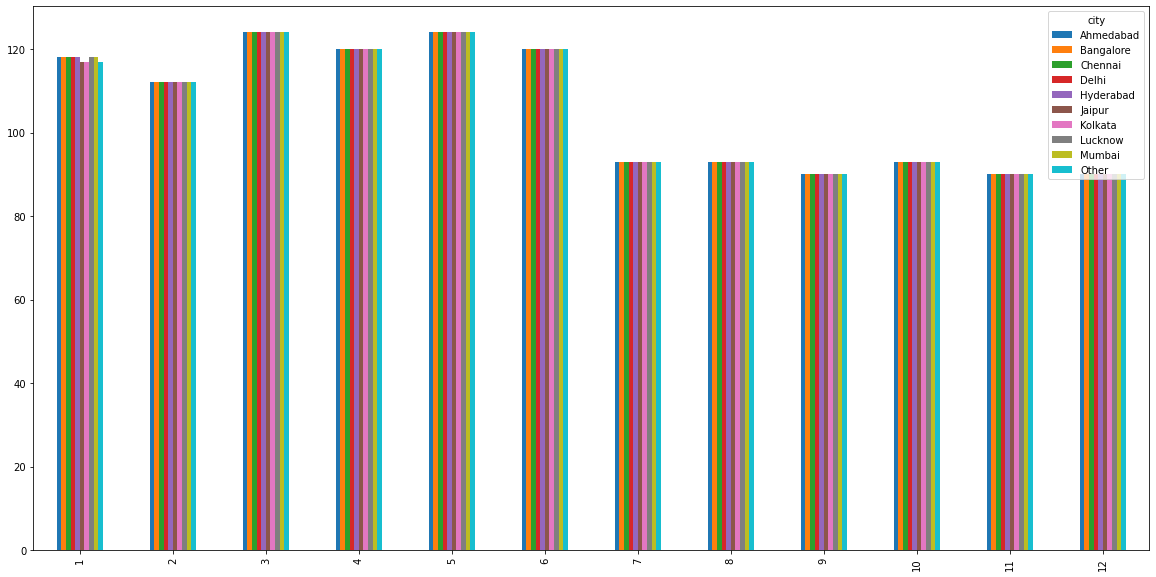

In [32]:
#Plotting the footfall yearwise
fig = plt.figure(figsize=(20,10))
axes = fig.add_subplot(1, 1, 1)
tfoot_fall.groupby(pd.DatetimeIndex(list(tfoot_fall.index)).month).count().plot(kind="bar", ax = axes)
plt.show()

In [33]:
#Footfall in 2018 is the least in all the cities

In [34]:
#Footfall is the least in the months of september, november and december. 
#Footfall is the highest in the months of March and May

(array([131., 285., 467., 262.,  87.,  18.,   5.,   4.,   5.,   3.]),
 array([ 5504.,  7460.,  9416., 11372., 13328., 15284., 17240., 19196.,
        21152., 23108., 25064.]),
 <BarContainer object of 10 artists>)

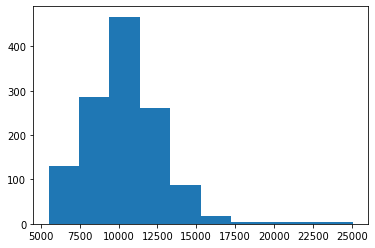

In [35]:
plt.hist(tfoot_fall['Ahmedabad'])

In [36]:
#Checking the correlation between cities
tfoot_fall.corr()

city,Ahmedabad,Bangalore,Chennai,Delhi,Hyderabad,Jaipur,Kolkata,Lucknow,Mumbai,Other
city,,,,,,,,,,
Ahmedabad,1.000000,0.811083,0.741345,0.814504,0.742798,0.596762,0.840455,0.698483,0.859310,0.758205
Bangalore,0.811083,1.000000,0.957016,0.962016,0.949290,0.609287,0.916764,0.915801,0.910781,0.916011
Chennai,0.741345,0.957016,1.000000,0.962561,0.979266,0.544047,0.883205,0.943654,0.879197,0.922876
Delhi,0.814504,0.962016,0.962561,1.000000,0.950719,0.614548,0.917783,0.932949,0.914809,0.909994
Hyderabad,0.742798,0.949290,0.979266,0.950719,1.000000,0.472640,0.852425,0.918095,0.858101,0.912860
Jaipur,0.596762,0.609287,0.544047,0.614548,0.472640,1.000000,0.768342,0.579117,0.726716,0.613951
Kolkata,0.840455,0.916764,0.883205,0.917783,0.852425,0.768342,1.000000,0.857028,0.931647,0.915966
Lucknow,0.698483,0.915801,0.943654,0.932949,0.918095,0.579117,0.857028,1.000000,0.850669,0.866458
Mumbai,0.859310,0.910781,0.879197,0.914809,0.858101,0.726716,0.931647,0.850669,1.000000,0.866922


In [37]:
#There is least correlation between Jaipur and the remaining cities

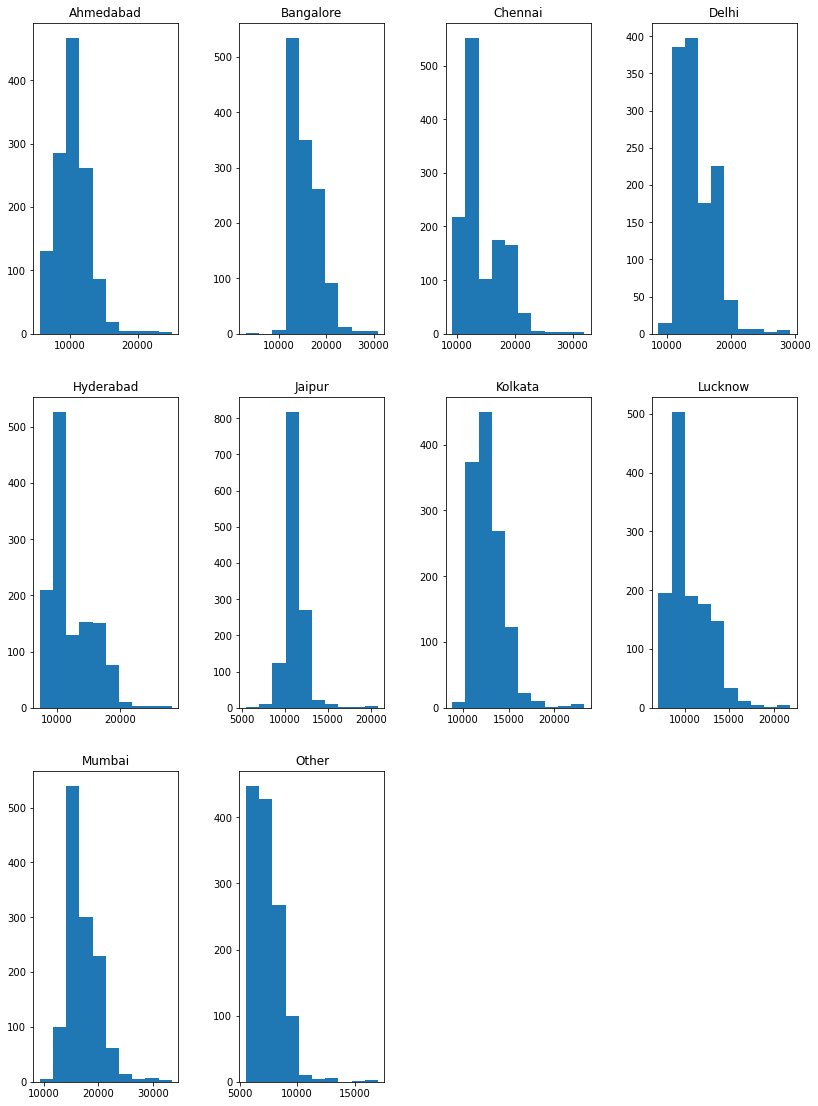

In [38]:
#Plotting citywise 
fig = plt.figure(figsize= (12,16))
for number, column in enumerate(tfoot_fall.columns):
    axes = fig.add_subplot(3, 4, number+1)
    fig.tight_layout(pad=3.0)
    axes.set_title(column.capitalize())
    plt.hist(tfoot_fall[column])

In [39]:
# Looking at the discounted data
disc_df.head()

,date,city,medicine,discounted
0,2016-04-01,1,1,0
1,2016-04-01,1,2,0
2,2016-04-01,1,3,0
3,2016-04-01,1,4,0
4,2016-04-01,1,5,0


In [40]:
disc_df['discounted'].value_counts(normalize=True)

0    0.953753
1    0.046247
Name: discounted, dtype: float64

In [41]:
#Very few medicines are discounted

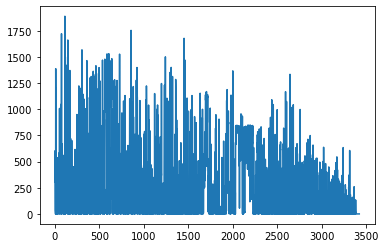

In [42]:
plt.plot(disc_df.groupby('medicine').agg({'discounted':np.sum}))

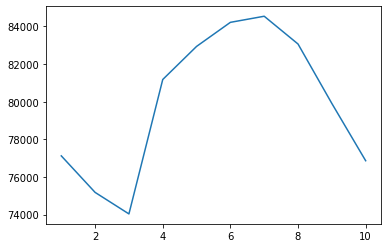

In [43]:
plt.plot(disc_df.groupby('city').agg({'discounted':np.sum}))

In [44]:
#City 7, Bangalore has the most discounts and city 3, Jaipur has the least

In [45]:
disc_df.shape

(17277949, 4)

In [46]:
disc_df.dtypes

date          object
city           int64
medicine       int64
discounted     int64
dtype: object

In [47]:
#Changing date object to datetime
disc_df['date'] = disc_df['date'].astype('datetime64[ns]')

In [48]:
#Merging discount and train data
df_merge = pd.merge(df, disc_df, on=["date", "city","medicine"], how="left")

In [49]:
df_merge.shape


(22669553, 5)

In [50]:
df_merge.head()

,date,city,medicine,sales,discounted
0,2015-01-02,1,1,24.0,NaN
1,2015-01-02,1,2,144.0,NaN
2,2015-01-02,1,3,84.0,NaN
3,2015-01-02,1,4,24.0,NaN
4,2015-01-02,1,5,8.0,NaN


In [51]:
df_merge.isnull().sum()

date                0
city                0
medicine            0
sales               0
discounted    6119931
dtype: int64

In [52]:
#Using 0 to fill in the NA values
df_merge['discounted'].fillna(0.0, inplace=True)

In [53]:
df_merge.isnull().sum()

date          0
city          0
medicine      0
sales         0
discounted    0
dtype: int64

In [54]:
df_merge["medicine"].nunique()

3389

In [55]:
#We can see that there is high cardinality in medicine

In [56]:
df_merge["weekday"] = df_merge['date'].dt.day_name()

In [57]:
df_merge["month"] = df_merge['date'].dt.month_name()

In [58]:
#Checking the data after adding month and weekday columns
df_merge.head()

,date,city,medicine,sales,discounted,weekday,month
0,2015-01-02,1,1,24.0,0.0,Friday,January
1,2015-01-02,1,2,144.0,0.0,Friday,January
2,2015-01-02,1,3,84.0,0.0,Friday,January
3,2015-01-02,1,4,24.0,0.0,Friday,January
4,2015-01-02,1,5,8.0,0.0,Friday,January


In [59]:
#Grouping data by sales
grouped_date = df_merge.groupby('date').agg({'sales':np.mean})
grouped_date

,sales
date,
2015-01-02,73.363795
2015-01-03,51.322000
2015-01-04,52.893989
2015-01-05,71.484540
2015-01-06,84.475803
...,...
2018-06-26,59.452640
2018-06-27,40.068460
2018-06-28,34.456871


In [60]:
grouped_date['date'] = grouped_date.index

In [61]:
grouped_date['date'] = pd.DatetimeIndex(grouped_date['date'])

In [62]:
grouped_date = grouped_date.set_index('date')

In [63]:
#Checking the sales by grouping the data during the year 2015 - 2018
#grouped_date['2015':'2018'].plot(figsize=(20,10))

In [64]:
#The above graph shows there is a spike in sales in the month of January every year

In [65]:
df_merge.describe(include='all')

,date,city,medicine,sales,discounted,weekday,month
count,22669553,2.266955e+07,2.266955e+07,2.266955e+07,2.266955e+07,22669553,22669553
unique,1269,NaN,NaN,NaN,NaN,7,12
top,2018-02-28 00:00:00,NaN,NaN,NaN,NaN,Tuesday,March
freq,94815,NaN,NaN,NaN,NaN,3379093,2210126
first,2015-01-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
last,2018-06-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,5.488700e+00,1.170297e+03,5.167903e+01,3.273527e-02,NaN,NaN
std,NaN,2.849361e+00,8.021110e+02,1.100379e+02,1.779429e-01,NaN,NaN
min,NaN,1.000000e+00,1.000000e+00,-9.948000e+03,0.000000e+00,NaN,NaN
25%,NaN,3.000000e+00,5.110000e+02,1.200000e+01,0.000000e+00,NaN,NaN


In [66]:
#Observations : Minimum value in sales is negative. This might indicate that there was a demand but no supply
#Negative sales might mean items returned or a loss. Not imputing them with zero as they too contribute to sales.

In [67]:
#Checking for negative sales
df_negative = df_merge[df_merge["sales"] < 0]
df_negative.head()

,date,city,medicine,sales,discounted,weekday,month
17792,2015-01-03,6,117,-32.32,0.0,Saturday,January
73647,2015-01-08,4,50,-8.00,0.0,Thursday,January
83397,2015-01-09,2,785,-4.00,0.0,Friday,January
85164,2015-01-09,4,232,-8.00,0.0,Friday,January
86418,2015-01-09,5,253,-40.00,0.0,Friday,January


In [68]:
df_negative.shape

(1672, 7)

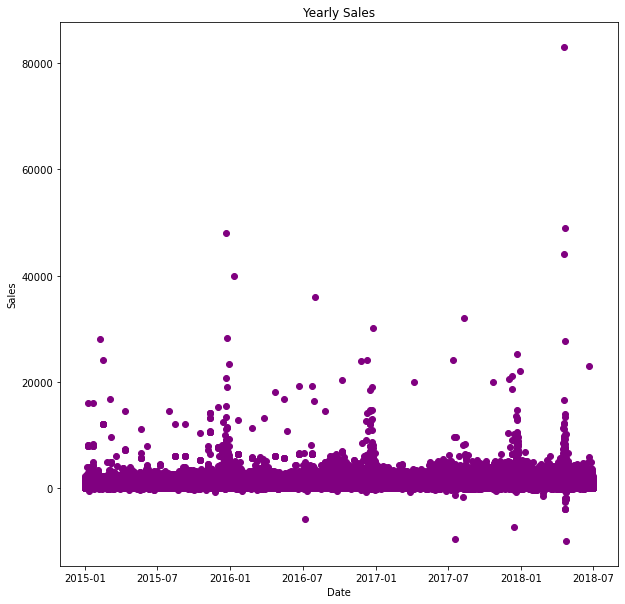

In [69]:
# Plotting the yearly sales to check graphically
fig, ax = plt.subplots(figsize=(10, 10))

# Adding x-axis and y-axis
ax.scatter(df_merge['date'].values,
           df_merge['sales'],
           color='purple')

# Setting title and labels for axes
ax.set(xlabel="Date",
       ylabel="Sales",
       title="Yearly Sales")

plt.show()

In [70]:
#Detect outliers in sales using boxplot

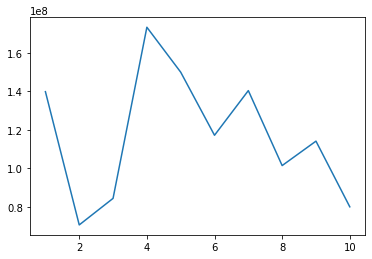

In [71]:

plt.plot(df_merge.groupby('city').agg({'sales':np.sum}))

In [72]:
#Sales is highest in city 4, Mumbai and least in city 2, Other

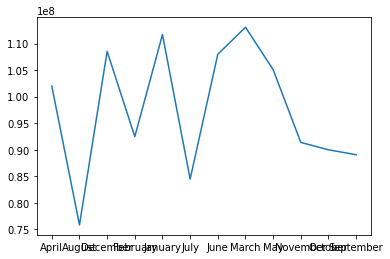

In [73]:
plt.plot(df_merge.groupby('month').agg({'sales':np.sum}))

In [74]:
#Sales is the highest in the month of March and lowest in the month of August

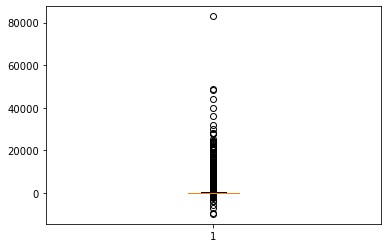

In [75]:
plt.boxplot(df_merge["sales"])
plt.show()

<AxesSubplot:title={'center':'sales'}, xlabel='city'>

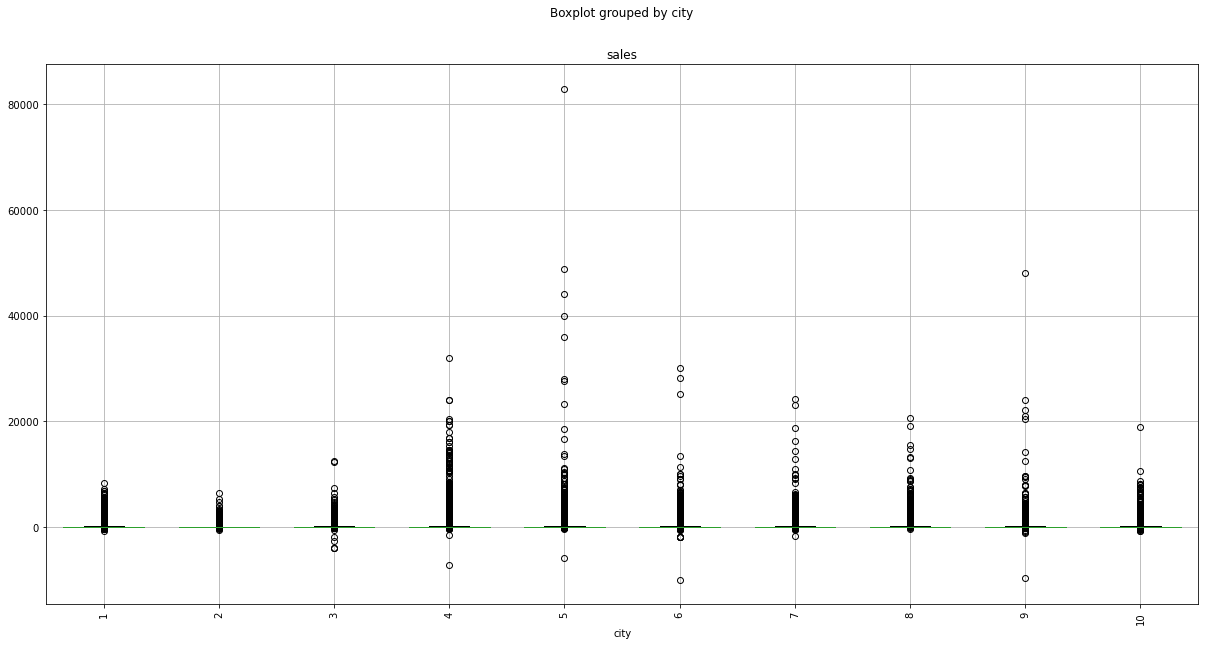

In [76]:
#Checking outliers by city
df_merge.boxplot("sales", by="city", rot=90, widths = 0.7, figsize=(20, 10))

In [77]:
# This shows that city 5, Delhi, has a vast variation in sales whereas city 2,other , has the least. 
# There's also a lot of negative sales/loss for city 3, Jaipur.
# All the cities have incurred at least some amount of loss.

In [78]:
#This definitely shows one outlier which exceeds 80000 sales for Delhi

<AxesSubplot:title={'center':'sales'}, xlabel='month'>

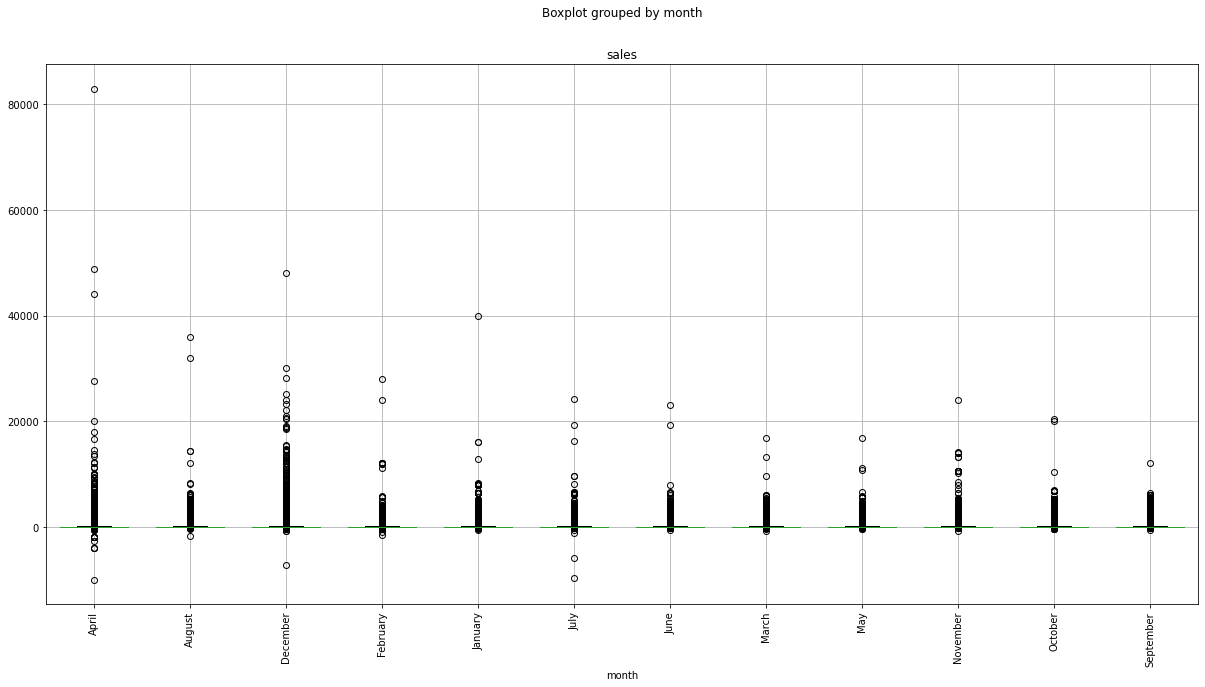

In [79]:
df_merge.boxplot("sales", by="month", rot=90, widths = 0.7, figsize=(20, 10))

In [80]:
#df_merge['sales'] = df_merge[df_merge['sales'] <= 80000]
df_merge.drop(df_merge[(df_merge['sales'] >= 80000) & (df_merge['sales'] <= 0)].index, inplace = True)

In [81]:
df_merge.dtypes

date          datetime64[ns]
city                   int64
medicine               int64
sales                float64
discounted           float64
weekday               object
month                 object
dtype: object

In [82]:
df_merge.corr()

,city,medicine,sales,discounted
city,1.000000,0.006877,-0.017790,0.004340
medicine,0.006877,1.000000,0.008180,0.064140
sales,-0.017790,0.008180,1.000000,0.054398
discounted,0.004340,0.064140,0.054398,1.000000


<AxesSubplot:>

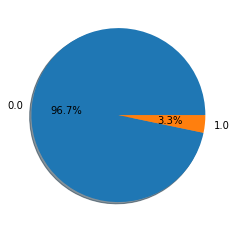

In [83]:
#Checking the discounted attribute
df_merge.groupby('discounted').size().plot(kind='pie', label="", autopct='%0.1f%%', shadow=True)

<AxesSubplot:>

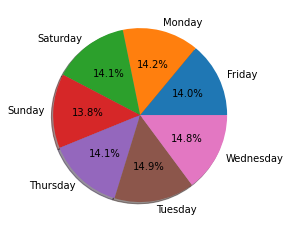

In [84]:
df_merge.groupby('weekday').size().plot(kind='pie', label="", autopct='%0.1f%%', shadow=True)

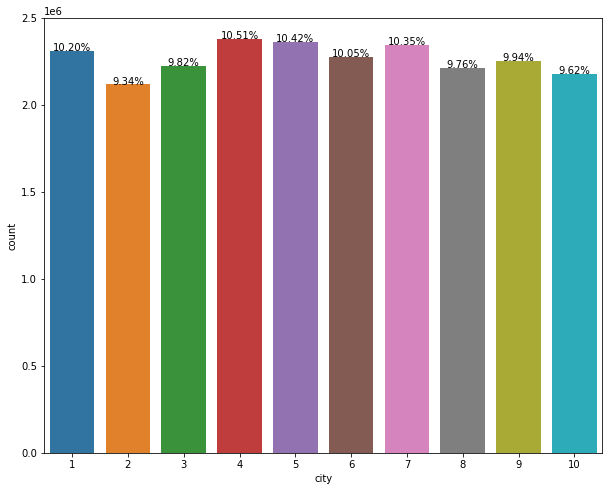

In [85]:
barplot("city",df_merge)

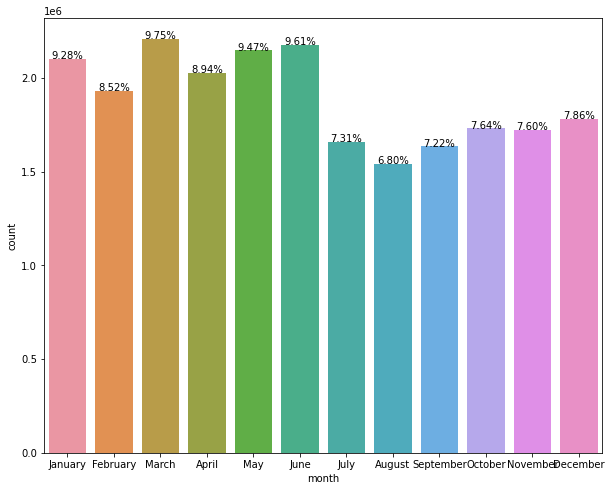

In [86]:
barplot("month", df_merge)

In [87]:
#Writing a method to display the percentages on top of the bar graphs
def show_percent(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12, ha="center")
    plt.show()

In [88]:
#Visualizing data to check which day of the week is the sale the highest
# plt.figure(figsize=(8, 6))
# plt.title('Sales by Day of the Week')
# ax = sns.countplot(df_merge['weekday'])
# show_percent(ax, df_merge['weekday'])

In [89]:
#Most sales are on tuesday probably because its the second day of the week and the least on Sunday probably because its a weekend

In [90]:
#Visualizing data to check which month is the sale the highest
# plt.figure(figsize=(8, 6))
# plt.title('Sales by Month')
# ax = sns.countplot(df_merge['month'])
# ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
# show_percent(ax, df_merge['month'])

In [91]:
#Month with highest sales is March and lowest is in the month of August

#### Target encoding Medicine

In [92]:
df_merge['year'] = df_merge['date'].dt.year
df_merge['month'] = df_merge['date'].dt.month
df_merge['day'] = df_merge['date'].dt.day

In [93]:
df_merge.set_index('date', inplace=True)

In [94]:
df_merge.head()

,city,medicine,sales,discounted,weekday,month,year,day
date,,,,,,,,
2015-01-02,1,1,24.0,0.0,Friday,1,2015,2
2015-01-02,1,2,144.0,0.0,Friday,1,2015,2
2015-01-02,1,3,84.0,0.0,Friday,1,2015,2
2015-01-02,1,4,24.0,0.0,Friday,1,2015,2
2015-01-02,1,5,8.0,0.0,Friday,1,2015,2


In [95]:
df_merge.drop(['weekday'], inplace=True, axis = 1)

In [96]:
# y = df_merge_removed_medicine["sales"]
# X = df_merge_removed_medicine.drop('sales', axis=1)
y = df_merge["sales"]
X = df_merge.drop('sales', axis=1)

In [97]:
print(X.shape)
print(y.shape)

(22669553, 6)
(22669553,)


In [98]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20,random_state=123)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(18135642, 6)
(4533911, 6)
(18135642,)
(4533911,)


In [99]:
num_attr = X_train.select_dtypes(['int64', 'float64']).columns
num_attr

Index(['city', 'medicine', 'discounted', 'month', 'year', 'day'], dtype='object')

In [100]:
cat_attr = X_train.select_dtypes('category').columns
cat_attr

Index([], dtype='object')

In [101]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr)])
#         ('cat', categorical_transformer, cat_attr)])

In [102]:
## Method to get the scores for each model
scores = pd.DataFrame(columns=['Model','rmse_train', 'rmse_test'])

def get_metrics(train_actual,train_predicted,test_actual,test_predicted,model_description,dataframe):
    
    rmse_train = np.mean((train_predicted - train_actual)**2)**.5
    rmse_test = np.mean((test_predicted - test_actual)**2)**.5
    dataframe = dataframe.append(pd.Series([model_description,rmse_train, rmse_test],
                                           index=scores.columns ), ignore_index=True)
    return(dataframe)

### 3. Observations

     * Month with highest sales is March and lowest is in the month of August
     * Most sales are on tuesday probably because its the 2nd day of the week and the least on Sunday probably 
       because its a weekend
     * There is one outlier which exceeds 80000 sales.
     * Minimum value in sales is negative. This might indicate that there was a demand but no supply
     * Negative sales might mean items returned or a loss. Not imputing them with zero as they too contribute to sales.
     * Footfall in 2018 is the least in all the cities
     * Footfall is the least in the months of september, november and december. 
     * Footfall is the highest in the months of March and May
     * There is least correlation between Jaipur and the remaining cities
     * Very few medicines are discounted
     * There is a spike in sales in the month of January every year
     * Delhi has the most variation in sales with sale exceeding 80000 at a time
     * There's also a lot of negative sales/loss for city 3, Jaipur.
     * All the cities have incurred at least some amount of loss.
     * Footfall is not directly related to Sales

## 4. Model_Building


### Time Series

In [123]:
df_t = df[['sales']]
df_t.head()

,sales
date,
2015-01-02,24.0
2015-01-02,144.0
2015-01-02,84.0
2015-01-02,24.0
2015-01-02,8.0


In [124]:
df_t.sort_index(inplace=True)

In [125]:
df_t = df_t.resample('D').last()

In [126]:
series = df_t.groupby("date").sum("sales")
series

,sales
date,
2015-01-02,16.0
2015-01-03,16.0
2015-01-04,12.0
2015-01-05,36.0
2015-01-06,20.0
...,...
2018-06-26,56.0
2018-06-27,32.0
2018-06-28,8.0


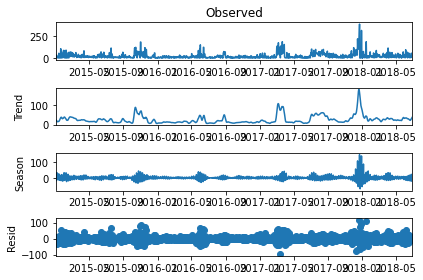

In [129]:
res = STL(series).fit()
res.plot()
plt.show()

In [130]:
from statsmodels.tsa.stattools import adfuller


def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [131]:
adf_test(series)

Results of Dickey-Fuller Test:
Test Statistic                   -5.169962
p-value                           0.000010
#Lags Used                       21.000000
Number of Observations Used    1254.000000
Critical Value (1%)              -3.435575
Critical Value (5%)              -2.863848
Critical Value (10%)             -2.567999
dtype: float64


In [132]:
# According to ADF test
# H0 :The series is not stationary
# H1 :The series is stationary
# At 95% confidence level, p being 0.000010, is less than alpha(0.05), so we reject the null hypothesis. 
# So we can see that our data is stationary.

In [135]:
model_MA = ARIMA(series, order=(0,0,1))

In [136]:
result = model_MA.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1276
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -6094.846
Date:                Sat, 25 Dec 2021   AIC                          12195.693
Time:                        18:56:40   BIC                          12211.147
Sample:                    01-02-2015   HQIC                         12201.497
                         - 06-30-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4316      1.630     15.602      0.000      22.237      28.626
ma.L1          0.4019      0.012     33.856      0.000       0.379       0.425
sigma2       824.7120     15.590     52.900      0.000     794.156     855.268
===================================================================================
Ljung-Box (L1) (Q):                  14.93   Jarque-Bera (JB):             24159.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.11   Skew:                             3.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [137]:
pred = result.predict(len(series), len(series)+30)

### LSTM

### Linear Regression

In [ ]:
X_train.shape
y_train.shape

In [189]:
lin_mod = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())])

In [190]:
lin_mod.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['city', 'day', 'discounted',
                                                   'medicine', 'month',
                                                   'year'])])),
                ('regressor', LinearRegression())])

In [191]:
y_pred_train = lin_mod.predict(X_train)
y_pred_val = lin_mod.predict(X_val)

### Evaluating Model Performance

In [192]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"LinearRegression",scores)
scores

,Model,rmse_train,rmse_test
0,LinearRegression,109.098224,105.69418
1,LinearRegression,109.098224,105.69418


### Decision Tree Regressor


In [169]:
# Create Decision Tree classifer object with pipeline
dt_mod = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', DecisionTreeRegressor(random_state=123))])

In [170]:
# set of parameters to test
dt_param_grid = {'regressor__criterion': ['mse'], 'regressor__max_depth': [6,8, 10, 12], 
                 "regressor__min_samples_split": [2, 10, 20],"regressor__min_samples_leaf": [1, 5, 10]}

In [171]:
# Using GridSearchCV 
dt_mod_grid = GridSearchCV(dt_mod, param_grid=dt_param_grid, cv=5,scoring=None)

In [ ]:
dt_mod_grid.fit(X_train, y_train)

In [197]:
y_pred_train = dt_mod_grid.predict(X_train)
y_pred_val = dt_mod_grid.predict(X_val)

In [198]:
scores = get_metrics(y_train,y_pred_train,y_val,y_pred_val,"DecisionTreeWithGridSearch",scores)
scores

,Model,rmse_train,rmse_test
0,LinearRegression,109.098224,105.694180
1,LinearRegression,109.098224,105.694180
2,DecisionTreeWithGridSearch,99.712795,95.884987


### Decision Tree with Randomized Search

### SVR

### Keras Tensorflow

In [ ]:
#pip install keras

In [ ]:
#pip install tensorflow

In [92]:
df_merge.head()

,city,medicine,sales,discounted,month,year,day
date,,,,,,,
2015-01-02,1,1,24.0,0.0,1,2015,2
2015-01-02,1,2,144.0,0.0,1,2015,2
2015-01-02,1,3,84.0,0.0,1,2015,2
2015-01-02,1,4,24.0,0.0,1,2015,2
2015-01-02,1,5,8.0,0.0,1,2015,2


In [133]:
#df_merge.drop(['weekday', 'medicine_encoded'], inplace=True, axis = 1)

In [93]:
df_merge.dtypes

city            int64
medicine        int64
sales         float64
discounted    float64
month           int64
year            int64
day             int64
dtype: object

In [136]:
#df_merge['city'] = df_merge['city'].astype("int64")

In [192]:
#df_merge['discounted'] = df_merge['discounted'].astype("int64")

In [94]:
cat_attr = list(df_merge.select_dtypes("category").columns)
#num_attr = list(df_merge.columns.difference(cat_attr))
num_attr = list(df_merge.select_dtypes(["int64", "float64"]).columns)
num_attr.remove("sales")
num_attr

['city', 'medicine', 'discounted', 'month', 'year', 'day']

In [95]:
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_attr)])

In [96]:
Y = df_merge.loc[:, "sales"]
#X = df_merge.loc[:, df_merge.columns != 'sales']
X = df_merge[df_merge.columns.difference(['sales', 'date'])]

In [97]:
#Split train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True)

In [98]:
#Count features for modelization
X_num_columns= len(X.columns)
X_num_columns

6

In [99]:
X.head()

,city,day,discounted,medicine,month,year
date,,,,,,
2015-01-02,1,2,0.0,1,1,2015
2015-01-02,1,2,0.0,2,1,2015
2015-01-02,1,2,0.0,3,1,2015
2015-01-02,1,2,0.0,4,1,2015
2015-01-02,1,2,0.0,5,1,2015


In [100]:
from keras import backend as K

In [101]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [102]:
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Activation
from keras import regularizers
# def create_model(optimizer='adam',
#                  kernel_initializer='glorot_uniform', 
#                  dropout=0.2):
def create_model(optimizer='rmsprop', 
                 dropout=0.2):
    model = Sequential()
    model.add(Dense(200,
                activation='relu',
                input_dim = X_num_columns))
#     model.add(Dense(190,
#                 activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(100,
                activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(40,
                activation='relu'))
    model.add(Dropout(0.2))
#     model.add(Dense(20,
#                 activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(7,
                activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,
                activation='relu'))
    model.compile(optimizer=optimizer, loss=root_mean_squared_error)
    return model

# wrap the model using the function you created
clf = KerasRegressor(build_fn=create_model,verbose=0,epochs=5, validation_split = 0.2)

# just create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', clf)])

In [160]:
X_train.head()

,city,day,discounted,medicine,month,year
date,,,,,,
2017-08-24,6,24,0.0,564,8,2017
2016-08-01,3,1,0.0,1735,8,2016
2017-08-16,4,16,0.0,2590,8,2017
2015-12-11,5,11,0.0,1714,12,2015
2018-03-21,6,21,0.0,727,3,2018


In [103]:
#model.fit(X_train, y_train, epochs=5, batch_size=10000)
pipeline.fit(X_train, y_train) 

print("Training completed")

Training completed


In [104]:
dates = df.index

### TEST DATA PREDICTION

In [130]:
df_test = pd.read_csv('test_data-1638434844061.csv', na_values=['unknown', '#', '$'])
# df_test = pd.read_csv('test_data-1638434844061.csv',
#                  parse_dates= {"date" : ["year","month","day"]}, index_col="date", na_values=['unknown', '#', '$'])

In [131]:
Id = df_test['id']

In [132]:
df_test.shape

(773535, 6)

In [133]:
df_test.head()

,id,year,month,day,city,medicine
0,1,2018,7,1,1,1292
1,2,2018,7,1,1,1
2,3,2018,7,1,1,2
3,4,2018,7,1,1,3
4,5,2018,7,1,1,4


In [134]:
df_test["date"] = pd.to_datetime(dict(year=df_test.year, month=df_test.month, day=df_test.day))
df_test.set_index(["date"], inplace=True)
df_test.drop(['id'], axis = 1, inplace=True)
df_test.head()

,year,month,day,city,medicine
date,,,,,
2018-07-01,2018,7,1,1,1292
2018-07-01,2018,7,1,1,1
2018-07-01,2018,7,1,1,2
2018-07-01,2018,7,1,1,3
2018-07-01,2018,7,1,1,4


In [135]:
disc_df.head()

,date,city,medicine,discounted,year,month,day
0,2016-04-01,1,1,0,2016,4,1
1,2016-04-01,1,2,0,2016,4,1
2,2016-04-01,1,3,0,2016,4,1
3,2016-04-01,1,4,0,2016,4,1
4,2016-04-01,1,5,0,2016,4,1


In [136]:
disc_df['year'] = disc_df['date'].dt.year

In [137]:
disc_df['month'] = disc_df['date'].dt.month

In [138]:
disc_df['day'] = disc_df['date'].dt.day

In [139]:
disc_df.head()

,date,city,medicine,discounted,year,month,day
0,2016-04-01,1,1,0,2016,4,1
1,2016-04-01,1,2,0,2016,4,1
2,2016-04-01,1,3,0,2016,4,1
3,2016-04-01,1,4,0,2016,4,1
4,2016-04-01,1,5,0,2016,4,1


In [140]:
#Merging discount and train data
df_merge_test = pd.merge(df_test, disc_df, on=["date", "city","medicine", "year", "month", "day"], how="left")

In [141]:
df_merge_test.head()

,date,year,month,day,city,medicine,discounted
0,2018-07-01,2018,7,1,1,1292,0
1,2018-07-01,2018,7,1,1,1,0
2,2018-07-01,2018,7,1,1,2,1
3,2018-07-01,2018,7,1,1,3,0
4,2018-07-01,2018,7,1,1,4,0


In [142]:
df_merge_test['discounted'].fillna(0.0, inplace=True)

In [143]:
df_merge_test['discounted'] = df_merge_test['discounted'].astype('float64')

In [144]:
df_merge_test.set_index("date", inplace=True)

In [145]:
cat_attr_test = list(df_merge_test.select_dtypes("category").columns)
num_attr_test = list(df_merge_test.columns.difference(cat_attr))
#num_attr_test.remove("sales")
num_attr_test

['city', 'day', 'discounted', 'medicine', 'month', 'year']

In [146]:
#test_data[catcols] = test_data[catcols].astype('category')

In [147]:
numeric_transformer_test = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_test, num_attr_test)])

In [161]:
cols = ['city','day',  'discounted', 'medicine', 'month', 'year']

In [162]:
df_merge_test = df_merge_test[cols]

In [150]:
#df_merge_test.head()

In [151]:
df_merge_test.dtypes

year            int64
month           int64
day             int64
city            int64
medicine        int64
discounted    float64
dtype: object

In [152]:
df_merge.dtypes

city            int64
medicine        int64
sales         float64
discounted    float64
month           int64
year            int64
day             int64
dtype: object

In [153]:
df_merge.head()

,city,medicine,sales,discounted,month,year,day
date,,,,,,,
2015-01-02,1,1,24.0,0.0,1,2015,2
2015-01-02,1,2,144.0,0.0,1,2015,2
2015-01-02,1,3,84.0,0.0,1,2015,2
2015-01-02,1,4,24.0,0.0,1,2015,2
2015-01-02,1,5,8.0,0.0,1,2015,2


In [163]:
df_merge_test.head()

,city,day,discounted,medicine,month,year
date,,,,,,
2018-07-01,1,1,0.0,1292,7,2018
2018-07-01,1,1,0.0,1,7,2018
2018-07-01,1,1,1.0,2,7,2018
2018-07-01,1,1,0.0,3,7,2018
2018-07-01,1,1,0.0,4,7,2018


In [164]:
#Predict upcoming sales using trained model and imported upcoming dates
Predicted_sales = pipeline.predict(df_merge_test)

In [165]:
Predicted_sales.shape

(773535,)

In [166]:
score_test = list(zip(Id.to_numpy(),Predicted_sales))

In [167]:
test_scores = pd.DataFrame(score_test, columns=['id','sales'])

In [168]:
test_scores.to_csv('Arpita_Banerjee_B94_Final_Hackathon.csv', index=False)

### Medicine Encoding

In [162]:
df_merge_test['medicine_encoded'] = df_merge_test.medicine.map(encoded_target)

In [116]:
df_merge_test.drop(['medicine'], axis = 1, inplace = True)

In [163]:
cat_attr = list(df_merge_test.select_dtypes("category").columns)
num_attr = list(df_merge_test.columns.difference(cat_attr))

In [164]:
cat_attr

[]

In [165]:
num_attr

['city', 'day', 'discounted', 'medicine', 'medicine_encoded', 'month', 'year']

In [120]:
numeric_transformer_test = Pipeline(steps=[
    ('scaler', StandardScaler())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_test, num_attr_test)])

In [121]:
X_train.shape

(35254, 22)

In [ ]:
#train_pred = dt_mod_random_best.predict(X_train)
test_pred = dt_mod_grid.predict(df_merge_test)

test_pred

In [363]:
test['Predictions']

date
2018-07-01    1.039266e+06
2018-07-02    1.015497e+06
2018-07-03    1.203428e+06
2018-07-04    1.285755e+06
2018-07-05    1.436735e+06
2018-07-06    1.414230e+06
2018-07-07    1.078778e+06
2018-07-08    1.147754e+06
2018-07-09    1.209731e+06
2018-07-10    1.278197e+06
2018-07-11    1.387956e+06
2018-07-12    1.434061e+06
2018-07-13    1.223884e+06
2018-07-14    9.898281e+05
2018-07-15    9.802975e+05
2018-07-16    1.005025e+06
2018-07-17    9.816096e+05
2018-07-18    1.176319e+06
2018-07-19    1.364864e+06
2018-07-20    1.462082e+06
2018-07-21    1.170251e+06
2018-07-22    1.179838e+06
2018-07-23    1.206932e+06
2018-07-24    1.259987e+06
2018-07-25    1.342422e+06
2018-07-26    1.406217e+06
2018-07-27    1.247285e+06
2018-07-28    9.890186e+05
2018-07-29    9.530264e+05
2018-07-30    9.587571e+05
2018-07-31    1.085178e+06
Freq: D, Name: Predictions, dtype: float64

In [365]:
score_test = list(zip(Id.to_numpy(),test['Predictions']))

In [366]:
test_scores = pd.DataFrame(score_test, columns=['id','sales'])

In [367]:
test_scores.to_csv('Arpita_Banerjee_B94_Final_hackathon.csv', index=False)

### 5. Overall_Insights
#### Excel Sheet Analysis
#### Number of footfall is not equivalent  to the number of sales. That means that there is demand but no supply. The following could be the probable reasons
       * The quality of medicines may not be good enough so they are being taken off the market and hence the crisis.
       * It could be that the retailers were making extra profit by selling online and hence the demand in stores were on the rise.
       
#### Metric : RMSE : validation : 95.8     test: 79.69
#### Best Model : 
    : Decision Tree Regressor 

# Thank You !!!